# Partial, and Full CNN predictiong S&P500 Daily Closing Price

The first model we will build will have a 1D CNN layer that acts as a preproccesser of our SPY data. A 1D-Conv layer acts exactly the same as a 2-D layer used in image processing except that it only operates in one dimension. In image processing the dimensions are height and width, while in our example here we are only worried 1 dimension-- Closing price.

As discussed previously, RNNs have memory stored in their hidden states. A 1D CNN layer does not have any memory as it only calculates an output based on the current filter size. A filter/kernel is just like our moving window.


## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  

def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  
def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [3]:
# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6949


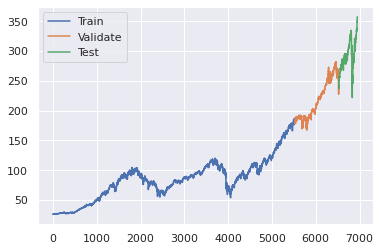

In [4]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [5]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

## Preprocessing With 1D-Convolutional Layers

### Padding

*   No padding - does not add 0's in place of missing data of input sequence. This shortens the sequence length due to the fact that the output will be missing values at the beginning and end due to window size.
*   Same padding - Same padding adds zeros to the left and right when data is missing in the kernel so that the output size matches the input size.
*   Causal Padding -  instead of padding 0's to the left and right it only pads 0's to the left. This is important when building a model for forecasting ensuring the model does not cheat and use future values to predict future values.


### Stride
Stride is how many time steps the kernel/window moves after calculating an input. For a stride of 1 and a kernel size of 3 it will first calculate an output on steps [1,2,3] and then move 1 stride to [2,3,4].


### Filters
The number of filters means how many different kernels are tested on each input sequence. A number too low the model will perform poorly while too many will overfit the data.

In [6]:
# Clear any backend results so that we start fresh
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input sequence batches
window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

# Create model
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=10,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
])

# Set learning rate finder
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

# Choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# Compile Model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Save history to plot learning rate
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
43/43 [==============================] - 1s 13ms/step - loss: 0.0921 - mae: 0.3706
Epoch 2/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0879 - mae: 0.3609
Epoch 3/100
43/43 [==============================] - 1s 13ms/step - loss: 0.0839 - mae: 0.3514
Epoch 4/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0794 - mae: 0.3411
Epoch 5/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0745 - mae: 0.3295
Epoch 6/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0689 - mae: 0.3160
Epoch 7/100
43/43 [==============================] - 1s 12ms/step - loss: 0.0626 - mae: 0.2997
Epoch 8/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0555 - mae: 0.2798
Epoch 9/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0475 - mae: 0.2552
Epoch 10/100
43/43 [==============================] - 1s 13ms/step - loss: 0.0394 - mae: 0.2254
Epoch 11/100
43/43 [=============================

(1e-06, 1.0, 0.0, 0.1)

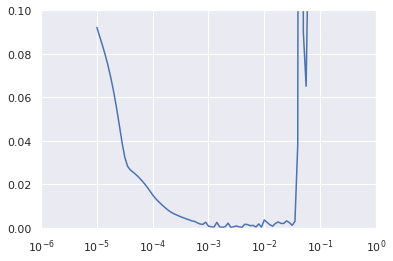

In [7]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .1])

In [8]:
# Clear any backend results so that we start fresh

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input sequence batches
window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
])

# Choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Create recall for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# Set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# Fit model to data
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
43/43 [==============================] - 1s 33ms/step - loss: 0.0126 - mae: 0.1116 - val_loss: 0.0735 - val_mae: 0.2485
Epoch 2/500
43/43 [==============================] - 1s 16ms/step - loss: 0.0066 - mae: 0.0691 - val_loss: 0.0471 - val_mae: 0.1728
Epoch 3/500
43/43 [==============================] - 1s 17ms/step - loss: 0.0039 - mae: 0.0452 - val_loss: 0.0357 - val_mae: 0.1189
Epoch 4/500
43/43 [==============================] - 1s 14ms/step - loss: 0.0030 - mae: 0.0398 - val_loss: 0.0331 - val_mae: 0.1601
Epoch 5/500
43/43 [==============================] - 1s 17ms/step - loss: 0.0030 - mae: 0.0428 - val_loss: 0.0223 - val_mae: 0.0959
Epoch 6/500
43/43 [==============================] - 1s 18ms/step - loss: 0.0018 - mae: 0.0302 - val_loss: 0.0188 - val_mae: 0.0945
Epoch 7/500
43/43 [==============================] - 1s 18ms/step - loss: 0.0014 - mae: 0.0251 - val_loss: 0.0146 - val_mae: 0.0820
Epoch 8/500
43/43 [==============================] - 1s 17ms/step - loss: 0.

In [9]:
# recall best model
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
# Forecast test data
rnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[x_test.index.min() - window_size:-1,-1,0]

In [11]:
# Scale data back to normal
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(422,)

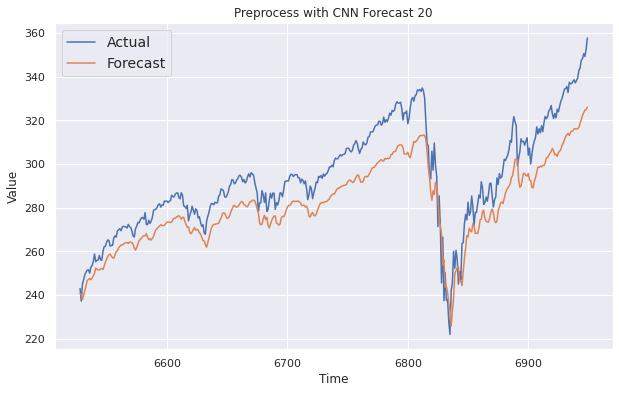

In [12]:
# Plot model results vs actual
plt.figure(figsize=(10, 6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'Preprocess with CNN Forecast {window_size}')
plot_series(x_test.index, x_test, label = 'Actual')
plot_series(x_test.index, rnn_unscaled_forecast, label = 'Forecast')

In [13]:
# Calculate MAE
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

12.655453